In [1]:
from lsmulator import *
from workloads import *
import numpy as np
import matplotlib.pyplot as plt
from figure_grid import *

# LSMulator Demo

The goal of this notebook is to show how simulations of our LSM tree perform under different workload conditions.

In [2]:
def show_queries(wls):
  qs = [wl.queries for wl in wls]
  maxy = max(max(q) for q in qs)
  maxx = len(qs[0])
  with figure_grid(1, len(wls)) as grid:
    for wl, ax in zip(wls, grid.each_subplot()):
      plt.title(wl.__str__())
      plt.xlim(0, maxx)
      if type(wl) == ZipfWorkload:
        plt.yscale("log")
      else:
        plt.ylim(0, maxy)
      q = wl.queries
      plt.scatter(range(len(q)), q, alpha=0.025)

In [3]:
zipfs = [ZipfWorkload(zipf_param=1.1),
         ZipfWorkload(zipf_param=1.25),
         ZipfWorkload(zipf_param=1.5)]

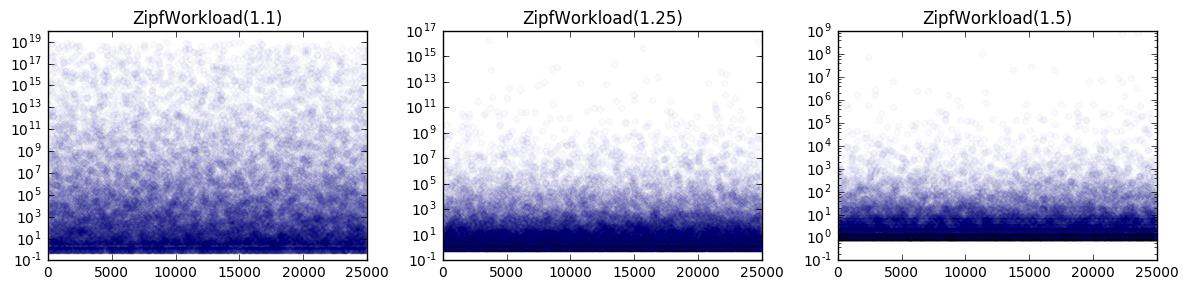

In [4]:
show_queries(zipfs)

In [5]:
mults = [MultinomialWorkload(),
         MultinomialWorkload(dist=scipy.stats.gamma(2)),
         MultinomialWorkload(dist=scipy.stats.expon(1))]

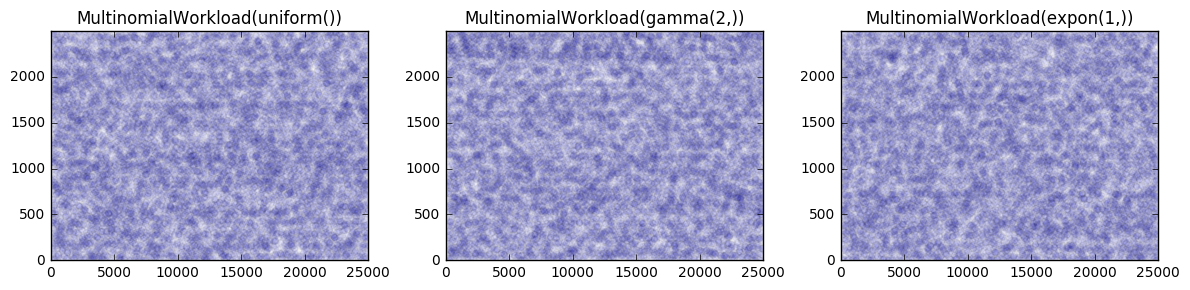

In [6]:
show_queries(mults)

In [7]:
timedecs = [TimeDecayBetaMultWorkload(),
            TimeDecayBetaMultWorkload(discoveries=scipy.stats.poisson(5)),
            TimeDecayBetaMultWorkload(decay_rate=scipy.stats.beta(10, 1)),
            TimeDecayBetaMultWorkload(decay_rate=scipy.stats.beta(1, 1))]

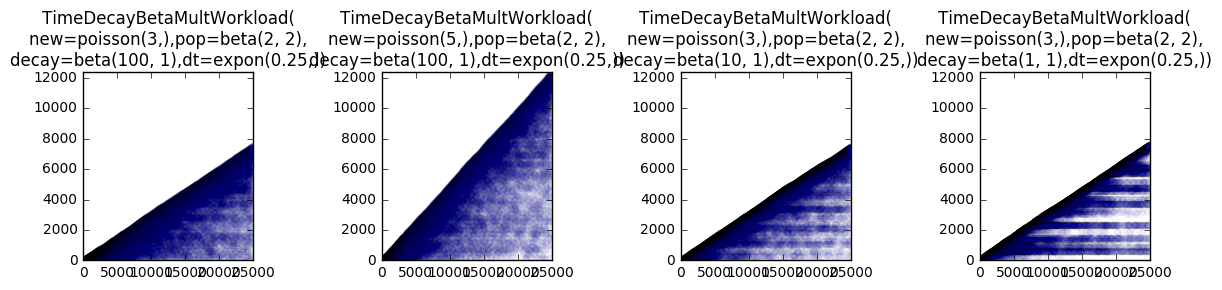

In [8]:
show_queries(timedecs)

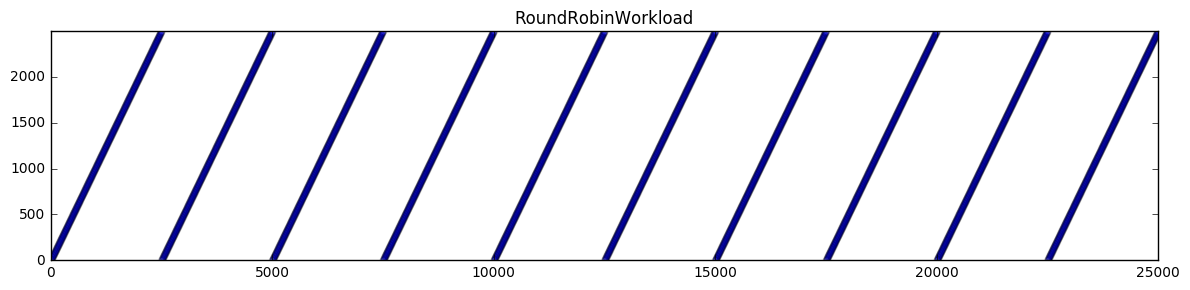

In [9]:
robins = [RoundRobinWorkload()]
show_queries(robins)

In [10]:
def plot_tree(lsmtree):
  layers = lsmtree.layers()
  cache = lsmtree.cache
  plt.bar(np.arange(len(layers)+1)-0.4, [cache.total_hits()]+[l.total_accesses() for l in layers])
  plt.xticks(range(len(layers)+1),
             ['Cache', 'Mtbl'] + ['L{}'.format(i) for i in range(1,len(layers))])
  plt.ylabel('# queries that access')
  plt.xlabel('LSM tree component')
  
def dictstr(h):
  return ', '.join(['{}={}'.format(k,v) for k,v in h.items()])
  
def plot_workload_trees(wls, title='', gridsize=None, **tree_options):
  trees = [lsmulate(wl.queries, **tree_options) for wl in wls]
  if gridsize is None:
    gridsize = (1, len(wls))
  with figure_grid(*gridsize) as grid:
    if title:
      grid.fig.suptitle('{}\n{}'.format(title, dictstr(tree_options)), y=1.15, fontsize=14)
    for i, ax in enumerate(grid.each_subplot()):
      plt.title(wls[i].__str__())
      plot_tree(trees[i])

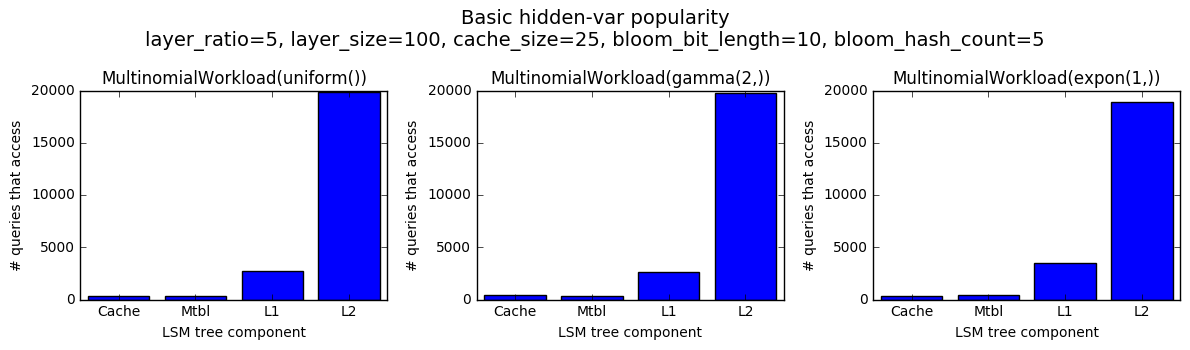

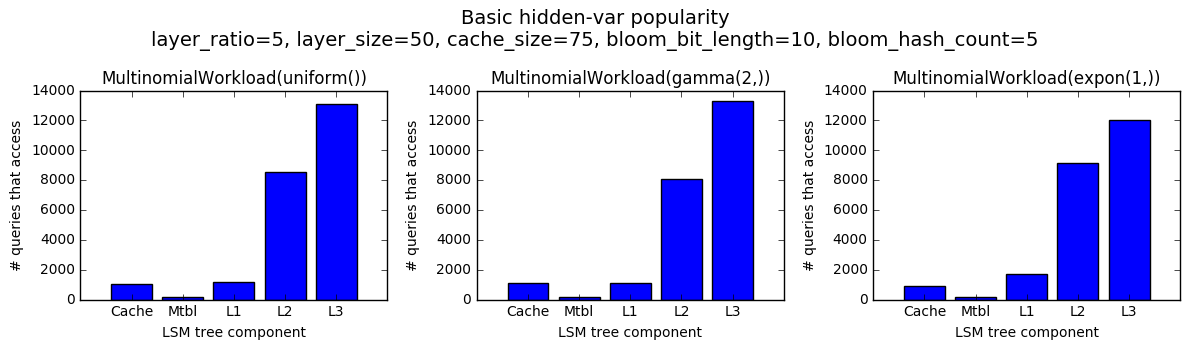

In [11]:
plot_workload_trees(mults, 'Basic hidden-var popularity',
    **{'cache_size': 25, 'layer_size': 100, 'layer_ratio': 5, 'bloom_bit_length': 10, 'bloom_hash_count': 5})

plot_workload_trees(mults, 'Basic hidden-var popularity',
    **{'cache_size': 75, 'layer_size': 50, 'layer_ratio': 5, 'bloom_bit_length': 10, 'bloom_hash_count': 5})

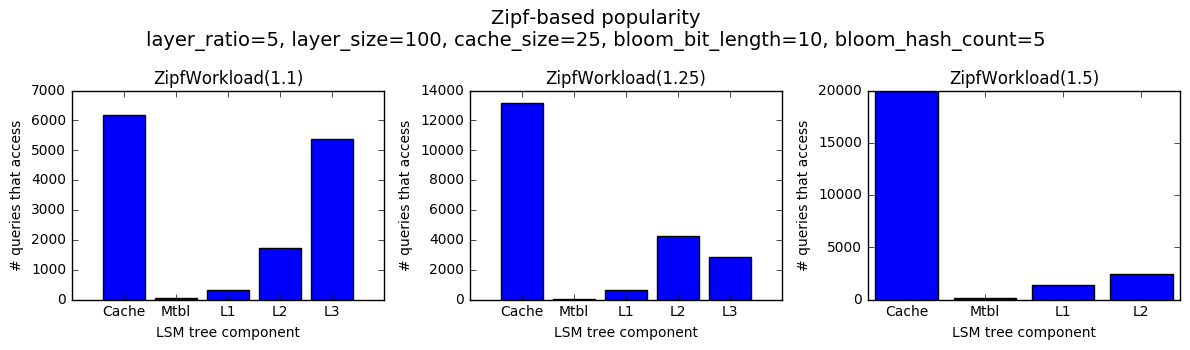

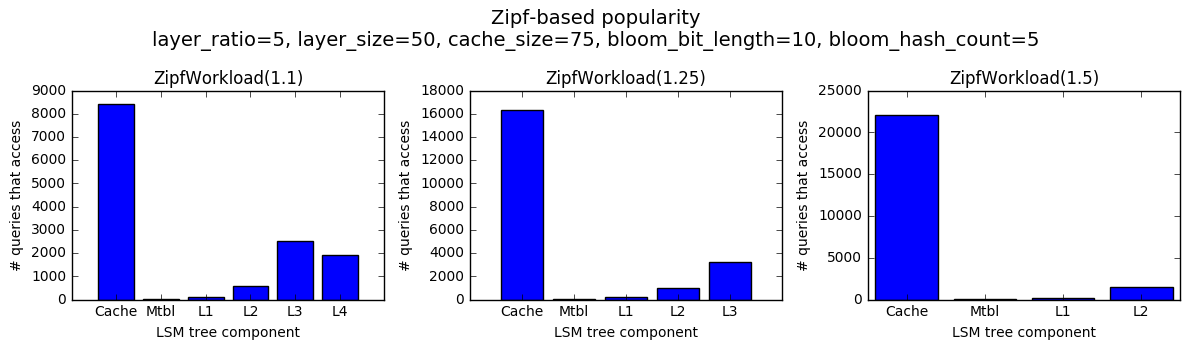

In [12]:
plot_workload_trees(zipfs, 'Zipf-based popularity',
    **{'cache_size': 25, 'layer_size': 100, 'layer_ratio': 5, 'bloom_bit_length': 10, 'bloom_hash_count': 5})

plot_workload_trees(zipfs, 'Zipf-based popularity',
    **{'cache_size': 75, 'layer_size': 50, 'layer_ratio': 5, 'bloom_bit_length': 10, 'bloom_hash_count': 5})

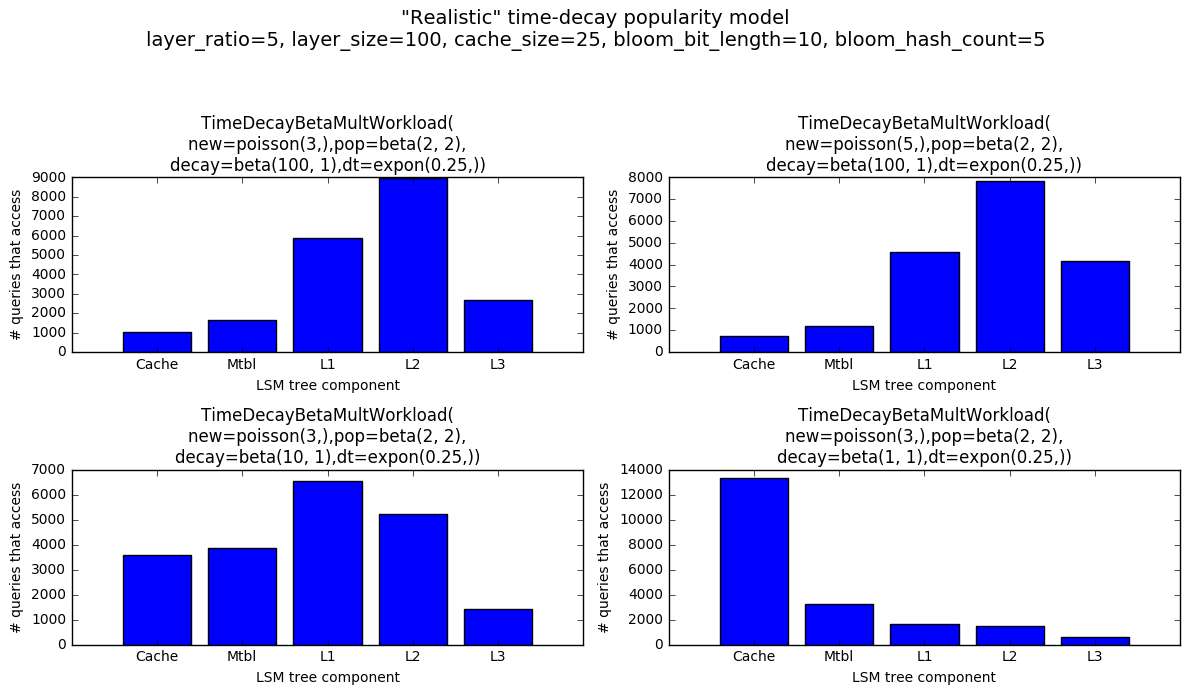

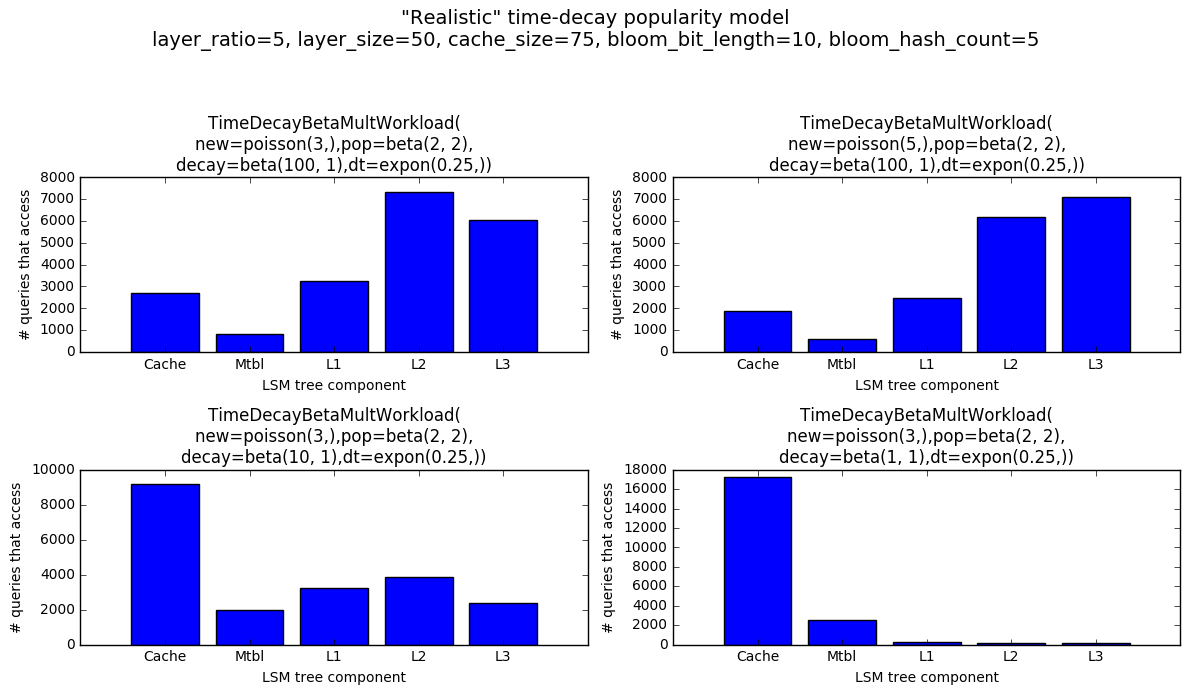

In [13]:
plot_workload_trees(timedecs, '"Realistic" time-decay popularity model', (2,2),
    **{'cache_size': 25, 'layer_size': 100, 'layer_ratio': 5, 'bloom_bit_length': 10, 'bloom_hash_count': 5})

plot_workload_trees(timedecs, '"Realistic" time-decay popularity model', (2,2),
    **{'cache_size': 75, 'layer_size': 50, 'layer_ratio': 5, 'bloom_bit_length': 10, 'bloom_hash_count': 5})